# 在一个难数据集上应用AdaBoost

1. 收集数据：提供的文本文件。
2. 准备数据：确保类别标签是+1和-1而非1和0。
3. 分析数据：手工检查数据。
4. 训练算法：在数据上，利用adaBoostTrainDS()函数训练出一系列的分类器。
5. 测试算法：我们拥有两个数据集。在不采用随机抽样的方法下，我们就会对AdaBoost和Logistic回归的结果进行完全对等的比较。
6. 使用算法：观察该例子上的错误率。不过，也可以构建一个Web网站，让驯马师输入马的症状然后预测马是否会死去。

In [1]:
import numpy as np

## 加载数据集，自适应数据加载函数

In [2]:
def loadDataSet(fileName):
    # 自动检测出特征的数目
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []; labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat - 1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        # 假定最后一个特征是类别标签
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [3]:
# 通过阈值比较对数据进行分类
def stumpClassify(dataMatrix, dimen, threshVal, threshIneq):
    # 将返回数组中的全部元素设置为1
    retArray = np.ones((np.shape(dataMatrix)[0], 1))
    # 所有满足不等式要求的元素设置为-1
    if threshIneq == 'lt':
        retArray[dataMatrix[:, dimen] <= threshVal] = -1
    else:
        retArray[dataMatrix[:, dimen] > threshVal] = -1
    return retArray

In [4]:
# 遍历所有的可能输入值，并找到数据集上最佳的单层决策树
def buildStump(dataArr, classLabels, D):
    # 将数据矩阵化
    dataMatrix = np.mat(dataArr); labelMat = np.mat(classLabels).T
    m, n = np.shape(dataMatrix)
    # bestStump 用于存储给定权重向量D时所得到的最佳单层决策树的相关信息
    # numSteps 用于在特征的所有可能值上进行遍历
    numSteps = 10; bestStump = {}; bestClasEst =np.mat(np.zeros((m, 1)))
    # 一开始就初始化成正无穷大，用于寻找可能的最小错误率
    minError = np.Inf
    # 在所有特征上遍历
    for i in range(n):
        rangeMin = dataMatrix[:, i].min(); rangeMax = dataMatrix[:, i].max();
        # 计算得到步长
        stepSize = (rangeMax - rangeMin) / numSteps
        # 从最左边开始设置阈值，-1的目的是从一开始就将最小点归为右侧
        for j in range(-1, int(numSteps) + 1):
            for inequal in ['lt', 'gt']:
                # 设置阈值
                threshVal = rangeMin + float(j) * stepSize
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m, 1)))
                # 如果predictedVals中的值不等于labelMat中的真正类别标签值，就设置为1
                # 否则设置为0
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T * errArr
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" % (i, threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClasEst

In [5]:
# dataArr 数据集，classLabels 类别标签, numIt 迭代次数
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    weakClassArr = []
    m = np.shape(dataArr)[0]
    # D是一个概率分布向量，所有的元素之和为1.0
    D = np.mat(np.ones((m, 1)) / m)
    # 记录每个数据点的类别估计累计值
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(numIt):
        #返回最小错误率的单层决策树，最小错误率，估计的类别向量
        bestStump, error, classEst = buildStump(dataArr, classLabels, D)
        #print("D: ", D.T)
        # 计算alpha值
        alpha = float(0.5 * np.log((1.0 - error)/ max(error, 1e-16)))
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        #print("classEst: ", classEst.T)
        # 计算下一次迭代的D
        expon = np.multiply(-1 * alpha * np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        # 错误率累加计算
        aggClassEst += alpha * classEst
        #print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T, np.ones((m, 1)))
        errorRate = aggErrors.sum() / m
        print("total error: ", errorRate, "\n")
        if errorRate == 0.0: break
    return weakClassArr, aggClassEst

In [6]:
# datToClass一个或多个待分类样例，classifierArr多个弱分类器
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m, 1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'], classifierArr[i]['thresh'], classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha'] * classEst
        #print(aggClassEst)
    return np.sign(aggClassEst)

In [7]:
dataArr, labelArr = loadDataSet('./horseColicTraining2.txt')

In [8]:
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 10)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



In [9]:
testArr, testLabelArr = loadDataSet('./horseColicTest2.txt')

In [10]:
prediction10 = adaClassify(testArr, classifierArray)

In [11]:
errArr = np.mat(np.ones((67, 1)))

In [12]:
errArr[prediction10 != np.mat(testLabelArr).T].sum()

16.0

使用10个分类器的时候，得到错分样例的个数是16个

## ROC曲线的绘制及AUC计算函数

In [13]:
# predStrengths: 分类器的预测强度，classLabels：类别标签
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    # 绘制光标的位置
    cur = (1.0, 1.0)
    # AUC值
    ySum = 0.0
    # 得到正例的总数
    numPosClas = sum(np.array(classLabels) == 1.0)
    # 确定步长
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    # 对预测强度进行排序，并得到索引，由小到大排序
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0; delY = yStep
        else:
            delX = xStep; delY = 0
            ySum += cur[1]
        # 从点(1.0,1.0)开始绘制，一直到(0,0)
        ax.plot([cur[0], cur[0] - delX], [cur[1], cur[1] - delY], c = 'b')
        cur = (cur[0] - delX, cur[1] - delY)
    # 绘制虚线
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('False Positive Rate'); plt.ylabel("True Positive Rate")
    plt.title("ROC curve for AdaBoost Horse Colic Detection System")
    ax.axis([0,1,0,1])
    plt.show()
    print("the Area Under the Curive is:", ySum * xStep)

### 10个弱分类器，AdaBoost算法性能AUC

In [14]:
dataArr, labelArr = loadDataSet('./horseColicTraining2.txt')

In [15]:
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 10)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 



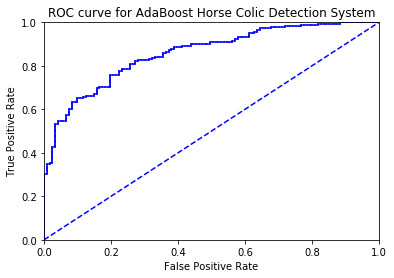

the Area Under the Curive is: 0.8582969635063604


In [16]:
plotROC(aggClassEst.T, labelArr)

### 50个弱分类器，AdaBoost算法性能AUC

In [17]:
classifierArray, aggClassEst = adaBoostTrainDS(dataArr, labelArr, 50)

total error:  0.2842809364548495 

total error:  0.2842809364548495 

total error:  0.24749163879598662 

total error:  0.24749163879598662 

total error:  0.25418060200668896 

total error:  0.2408026755852843 

total error:  0.2408026755852843 

total error:  0.22073578595317725 

total error:  0.24749163879598662 

total error:  0.23076923076923078 

total error:  0.2408026755852843 

total error:  0.2140468227424749 

total error:  0.22742474916387959 

total error:  0.21739130434782608 

total error:  0.22073578595317725 

total error:  0.21739130434782608 

total error:  0.22408026755852842 

total error:  0.22408026755852842 

total error:  0.23076923076923078 

total error:  0.22408026755852842 

total error:  0.2140468227424749 

total error:  0.20735785953177258 

total error:  0.22408026755852842 

total error:  0.22408026755852842 

total error:  0.2140468227424749 

total error:  0.22073578595317725 

total error:  0.2040133779264214 

total error:  0.20735785953177258 

t

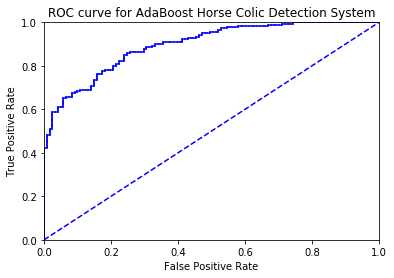

the Area Under the Curive is: 0.8953941870182941


In [18]:
plotROC(aggClassEst.T, labelArr)